# Markov Chain Monte Carlo (MCMC) sampling, part I: the basics

Markov Chain Monte Carlo (MCMC) is a powerful class of methods to sample from probability distributions known only up to an (unknown) normalization constant.
But before we dive into MCMC, let's consider why you might want to do sampling in the first place.  
The answer to that is: whenever you need to fully characterize a distribution because you're either interested in the samples themselves or because you need them to approximate expectations of functions w.r.t. to a probability distribution.
Sometimes, only the mode of a probability distribution is of primary interest. In this case, it can be obtained by numerical optimization and full sampling is not necessary. 
It turns out that sampling from any but the most basic probability distributions is a difficult task, because for those, you usually don't know the normalization constant.
You then can't easily get random numbers distributed according to this distribution: [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling) requires proper, normalized distributions.
Now in principle you could just obtain the normalization constant by numerical integration, but this quickly gets infeasible with increasing number of dimensions.
[Rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling) does not require normalized distributions, but implementing it efficiently can be very hard and requires a good deal of knowledge about the distribution of interest.
That's when you need a smart way to obtain representative samples from your distribution which doesn't require knowledge of the normalization constant.  
MCMC algorithms are a class of methods which do exactly that.
These methods date back to a seminal paper by Metropolis et al., who developed the first MCMC algorithm, correspondingly called [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), to calculate the equation of state of a two-dimensional system of hard spheres, but really were looking for a general method to calculate expectation values occurring in statistical physics.   

In this series of blog posts, I will introduce several important, increasingly complex MCMC algorithms.
Along the way, I hope you will acquire a solid understanding of challenges you may face when sampling from non-standard probability distributions and how to address them with the methods presented here.   

## Markov chains

Now that we know why we want to sample, let's get to the heart of MCMC &mdash; Markov chains.
What is a Markov chain?
Really informally and without all the technical details, a Markov chain is a random sequence of states in some state space in which the probability of picking a certain state next depends only on the current state in the chain and not on the previous history: it is memory-less.
Under certain conditions, a Markov chain has a unique stationary distribution of states to which it will converge after a certain number of states.
From that number on, states in the Markov chain will be distributed according to the invariant distribution.
MCMC algorithms work by constructing a Markov chain with the probability distribution you want to sample from as the stationary distribution.

For didactic purposes, let's for now consider both a discrete state space and discrete "time".
The key quantity characterizing a Markov chain is the transition operator $T(x_{i+1}|x_i)$ which gives you the probability of being in state $x_{i+1}$ at time $i+1$ given that the chain is in state $x_i$ at time $i$.

Now just for fun (and for illustration), let's quickly whip up a Markov chain which has a unique stationary distribution.
We'll start with some imports and settings for the plots:

In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

The Markov chain will hop around on a discrete state space which is made up from three weather states:

In [2]:
state_space = ("sunny", "cloudy", "rainy")

In a discrete state space, the transition operator is just a matrix.
Columns and rows correspond, in our case, to sunny, cloudy, and rainy weather.
We pick more or less sensible values for all transition probabilities:

In [3]:
transition_matrix = np.array(((0.6, 0.3, 0.1),
                              (0.3, 0.4, 0.3),
                              (0.2, 0.3, 0.5)))

The rows indicate the states the chain might currently be in and the columns the states the chains might transition to.
If we take one "time" step of the Markov chain as one hour, then, if it's sunny, there's a 60% chance it stays sunny in the next hour, a 30% chance that in the next hour we will have cloudy weather and only a 10% chance of it raining immediately after it had been sunny before.
This also means that each row has to sum up to one.

Let's run our Markov chain for a while:

In [4]:
n_steps = 20000
states = [0]
for i in range(n_steps):
    states.append(np.random.choice((0, 1, 2), p=transition_matrix[states[-1]]))
states = np.array(states)

We can monitor the convergence of our Markov chain to its stationary distribution by calculating the empirical probability for each of the states as a function of chain length:

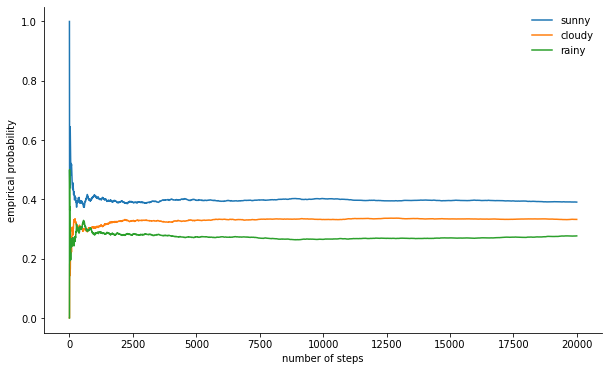

In [5]:
def despine(ax, spines=('top', 'left', 'right')):
    for spine in spines:
        ax.spines[spine].set_visible(False)

fig, ax = plt.subplots()
width = 1000
offsets = range(1, n_steps, 5)
for i, label in enumerate(state_space):
    ax.plot(offsets, [np.sum(states[:offset] == i) / offset 
            for offset in offsets], label=label)
ax.set_xlabel("number of steps")
ax.set_ylabel("empirical probability")
ax.legend(frameon=False)
despine(ax, ('top', 'right'))
plt.show()

## The mother of all MCMC algorithms: Metropolis-Hastings

So all that is fun, but back to sampling an arbitrary probability distribution $\pi$. 
It could either be discrete, in which case we would keep talking about a transition matrix $T$, or it could be continous, so that $T$ would be a transition *kernel*.
From now on, we're considering continuous distributions, but all concepts presented here transfer to the discrete case.  
If we could design the transition kernel in such a way that the next state is already drawn from $\pi$, we would be done, as our Markov Chain would... well...  immediately sample from $\pi$.
Unfortunately, to do this, we need to be able to sample from $\pi$, which we can't.
Otherwise you wouldn't be reading this, right?  
A way around this is to split up the transition kernel $T(x_{i+1}|x_i)$ into two parts:
a proposal distribution $q(x_{i+1}|x_i)$, from which we can sample possible next states, and an acceptance probability $p_\mathrm{acc}(x_{i+1}|x_i)$ which determines if a proposal $x_{i+1}$ is accepted as the next state in the chain or not.
This acceptance / rejection step corrects for the error introduced by proposal states from $q \neq \pi$.
We thus have 
$$
T(x_{i+1}|x_i)=q(x_{i+1} | x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) \ \mbox .
$$
A sufficient condition for a Markov chain to have $\pi$ as its stationary distribution is the transition kernel obeying *detailed balance* or, more intuitively, *microscopic reversibility*:
$$
\pi(x_i) T(x_{i+1}|x_i) = \pi(x_{i+1}) T(x_i|x_{i+1})
$$
This means that the probability of being in a state $x_i$ and transitioning to $x_{i+1}$ must be equal to the probability of the reverse process, namely, being in state $x_{i+1}$ and transitioning to $x_i$.
Transition kernels of most MCMC algorithms satisfy this condition.   
For the two-part transition kernel to obey detailed balance, we need to choose $p_\mathrm{acc}$ correctly, meaning that is has to correct for any asymmetries in probability flow from / to $x_{i+1}$ or $x_i$.
One possibility is the Metropolis acceptance criterion: 
$$
p_\mathrm{acc}(x_{i+1}|x_i) = \mathrm{min} \left\{1, \frac{\pi(x_{i+1}) \times q(x_i|x_{i+1})}{\pi(x_i) \times q(x_{i+1}|x_i)} \right\} \ \mbox .
$$
Often, symmetric proposal distributions with $q(x_i|x_{i+1})=q(x_{i+1}|x_i)$ are used, in which case the Metropolis-Hastings algorithm reduces to the original, but less general Metropolis algorithm developed in 1953 and for which
$$
p_\mathrm{acc}(x_{i+1}|x_i) = \mathrm{min} \left\{1, \frac{\pi(x_{i+1})}{\pi(x_i)} \right\} \ \mbox .
$$
Formally, we can then write the complete Metropolis-Hastings transition kernel as
$$
T(x_{i+1}|x_i) = \begin{cases}
                   q(x_{i+1}|x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) &: x_{i+1} \neq x_i \mbox ; \\
                   1 - \int \mathrm{d}x_{i+1} \ q(x_{i+1}|x_i) \times p_\mathrm{acc}(x_{i+1}|x_i) &: x_{i+1} = x_i\mbox .
                 \end{cases} 
$$
A step is then performed as follows: a proposal state $x_{i+1}$ is drawn from $q(x_{i+1}|x_i)$.
It is then accepted as the next state with probability $p_\mathrm{acc}(x_{i+1}|x_i)$ or rejected with probability $1-p_\mathrm{acc}(x_{i+1}|x_i)$, in which case the current state is copied as the next state.  


Alright, now that we now how Metropolis-Hastings works, let's go ahead and implement it.
First, we set the log-probability of the distribution we want to sample from - without normalization constants, as we pretend we don't know them.
Let's work for now with a standard normal distribution:

In [6]:
def log_prob(x):
     return -0.5 * np.sum(x ** 2)

Next, we choose a symmetric proposal distribution.
In general, including information you have about the distribution you want to sample from in the proposal distribution will lead to better performance of the Metropolis-Hastings algorithm. 
A naive approach is to just take the current state $x$ and pick a proposal from $\mathcal{U}(x-\frac{\Delta}{2}, x+\frac{\Delta}{2})$, that is, we set some step size $\Delta$ and move left or right a maximum of $\frac{\Delta}{2}$ from our current state:

In [7]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

Finally, we calculate our acceptance probability:

In [8]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

Now we piece all this together into our really brief implementation of a Metropolis-Hastings sampling step:

In [12]:
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    # here we determine whether we accept the new state or not:
    # we draw a random number uniformly from [0,1] and compare
    # it with the acceptance probability
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

Apart from the next state in the Markov chain, `x_new` or `x_old`, we also return whether the MCMC move was accepted or not.
This will allow us to keep track of the acceptance rate.
Let's complete our implementation by writing a function that iteratively calls `sample_MH` and thus builds up the Markov chain:

In [13]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

Now you're probably excited to see this in action.
Here we go, taking some informed guesses at the `stepsize` and `n_total` arguments:

In [14]:
chain, acceptance_rate = build_MH_chain(np.array([2.0]), 3.0, 10000, log_prob)
chain = [state for state, in chain]
print("Acceptance rate: {:.3f}".format(acceptance_rate))
last_states = ", ".join("{:.5f}".format(state) 
                        for state in chain[-10:])
print("Last ten states of chain: " + last_states)

Acceptance rate: 0.719
Last ten states of chain: 1.60194, 0.14617, -1.13052, 0.24360, -0.77219, -0.59475, 0.67935, 1.47293, 1.27589, 0.67263


Alright.
So did this work?
We achieved an acceptance rate of around 71% and we have a chain of states.
We should throw away the first few states during which the chain won't have converged to its stationary distribution yet.
Let's check whether the states we drew are actually normally distributed:

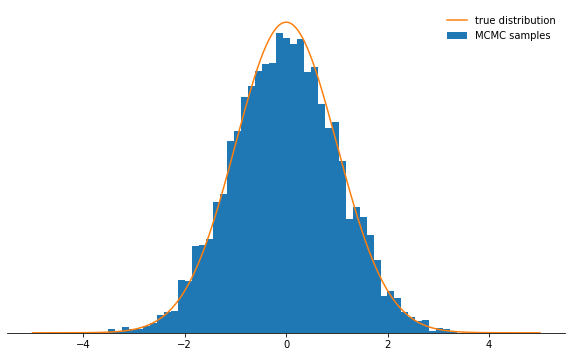

In [15]:
def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)
    
fig, ax = plt.subplots()
plot_samples(chain[500:], log_prob, ax)
despine(ax)
ax.set_yticks(())
plt.show()

Looks great!

Now, what's up with the parameters `stepsize` and `n_total`?
We'll discuss the step size first: it determines how big the random steps are the Markov chain takes.
If the step size is too large, we will jump around a lot in the tails of the distribution, where probability is low.
The Metropolis-Hastings sampler will reject most of these moves, meaning that the acceptance rate decreases and convergence is much slower.
See for yourself:

Acceptance rate: 0.104


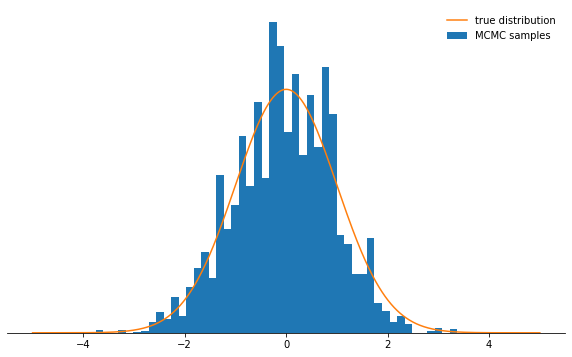

In [16]:
def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    despine(ax)
    ax.set_yticks(())
    plt.show()
    
sample_and_display(np.array([2.0]), 30, 10000, 500, log_prob)

Not so cool, right?
Now you could think the best thing to do is do choose a tiny step size.
Turns out that this is not too smart, either, because then the Markov chain will explore the probability distribution only very slowly and thus again won't converge as rapidly as with a well-adjusted step size:

Acceptance rate: 0.985


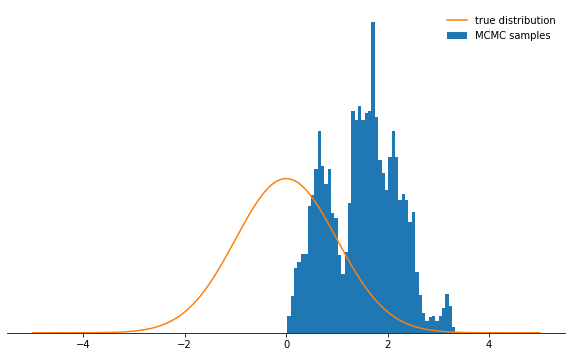

In [17]:
sample_and_display(np.array([2.0]), 0.1, 10000, 500, log_prob)

No matter how you choose the step size parameter, the Markov chain will eventually converge to its stationary distribution.
But it may take a looooong time.
The time we simulate the Markov chain for is set by the `n_total` parameter - it simply determines how many states we will end up with.
If the chain converges slowly, we need to increase `n_total` in order to give the Markov chain enough time to forget it's initial state.
So let's keep the tiny step size and increase the number of samples by increasing `n_total`:

Acceptance rate: 0.990


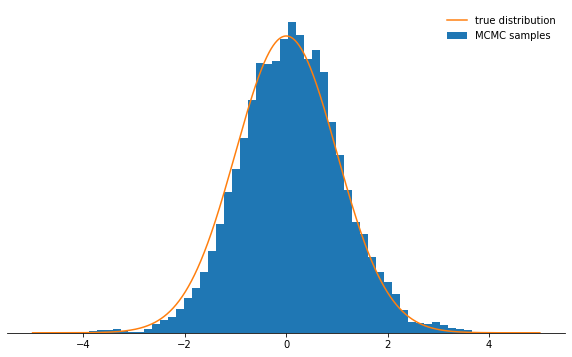

In [18]:
sample_and_display(np.array([2.0]), 0.1, 500000, 25000, log_prob)

Sloooowly getting there...

## Conclusions

With these considerations, I conclude the first blog post of this series.
I hope you now understand the intuition behind the Metropolis-Hastings algorithm, its parameters and why it is an extremely useful tool to sample from non-standard probability distributions you might encounter out there in the wild.  
I highly encourage you to play around with the code in this notebook - this way you will learn how the algorithm behaves in various circumstances and deepen your understanding of it.
Go ahead and try out a non-symmetric proposal distribution!
What happens if you don't adjust the acceptance criterion accordingly?
What happens if you try to sample from a bimodal distribution?
Can you think of a way to automatically tune the stepsize?
What are pitfalls here?
Try out and discover yourself!  
In the next post, I will discuss the Gibbs sampler - a special case of the Metropolis-Hastings algorithm which allows you to approximately sample from a multivariate distribution by sampling from the conditional distributions.